<a href="https://colab.research.google.com/github/limhasic/tqk/blob/master/%EA%B0%95%EC%9D%98%EC%9E%90%EB%A3%8C_%EA%B0%9D%EC%B2%B4%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

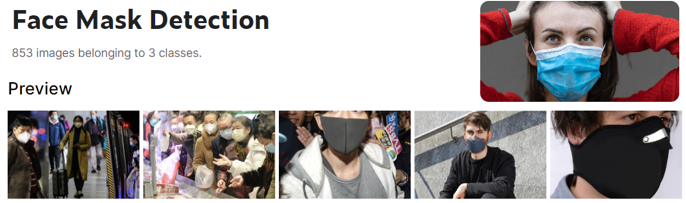

# 객체 탐지 
* 1. 라이브러리 설정
* 2. 데이터 불러오기
* 3. 데이터 EDA
* 4. 객체 탐지 모델
* 5. ...



In [ ]:
!pip install kaggle # kaggle 라이브러리 설치
from google.colab import files # colab 라이브러리 가져오기 
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasiclim","key":"9f64a79ffe5ffd4a8c6e5624af84e49f"}'}

In [ ]:
# 데이터 받아오기
!ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
# 나에 대한 읽기(4) 쓰기(1) 권한부여 설정
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 해당 
!kaggle competitions download -c open-images-2019-object-detection

100% 9.68G/9.69G [01:19<00:00, 130MB/s]
100% 9.69G/9.69G [01:19<00:00, 131MB/s]


In [ ]:
# 압축 해제
!unzip -q open-images-2019-object-detection 

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 96% 382M/398M [00:03<00:00, 77.7MB/s]
100% 398M/398M [00:03<00:00, 135MB/s] 


# 의료용 마스크 객체 탐지 모델 구축


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [ ]:
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

Downloading...
From: https://drive.google.com/uc?id=1pJtohTc9NGNRzHj5IsySR39JIRPfkgD3
To: /content/Face Mask Detection.zip
100% 417M/417M [00:04<00:00, 96.0MB/s]
Face Mask Detection.zip download complete!


In [ ]:
!unzip -q Face\ Mask\ Detection.zip

In [ ]:
# 데이터셋 확인

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse("/content/annotations/maksssksksss0.xml")
root = tree.getroot()

In [ ]:
for i in root:
  print(i)

<Element 'folder' at 0x7fcc24f63fb0>
<Element 'filename' at 0x7fcc24f5b230>
<Element 'size' at 0x7fcc24f5b2f0>
<Element 'segmented' at 0x7fcc24f5b710>
<Element 'object' at 0x7fcc24f5b6b0>
<Element 'object' at 0x7fcc24f5bad0>
<Element 'object' at 0x7fcc248ef2f0>


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches #사각형을 만들어줌
from bs4 import BeautifulSoup

In [ ]:
img_list = sorted(glob.glob('images/*'))
annot_list = sorted(glob.glob('annotations/*'))

In [ ]:
print(len(img_list))
print(len(annot_list))

#853 장의 이미지와 anotation 파일들

853
853


In [ ]:
print(img_list[:10])
print(annot_list[:10])

['images/maksssksksss0.png', 'images/maksssksksss1.png', 'images/maksssksksss10.png', 'images/maksssksksss100.png', 'images/maksssksksss101.png', 'images/maksssksksss102.png', 'images/maksssksksss103.png', 'images/maksssksksss104.png', 'images/maksssksksss105.png', 'images/maksssksksss106.png']
['annotations/maksssksksss0.xml', 'annotations/maksssksksss1.xml', 'annotations/maksssksksss10.xml', 'annotations/maksssksksss100.xml', 'annotations/maksssksksss101.xml', 'annotations/maksssksksss102.xml', 'annotations/maksssksksss103.xml', 'annotations/maksssksksss104.xml', 'annotations/maksssksksss105.xml', 'annotations/maksssksksss106.xml']


In [ ]:
def generate_box(obj):
    # 박스 만들기 : 좌표 값 가져오기
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # 레이블 분류하기 1 : 쓴사람, 2 : 안 쓴사람, 0 : 이상한 사람
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    # 타겟 파일 설정
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image(img_path, annotation):
    # 이미지에 띄우기
    img = mpimg.imread(img_path)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
img_list.index('images/maksssksksss307.png') 

232

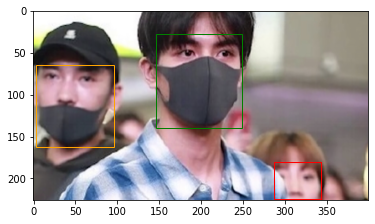

In [ ]:
bbox = generate_target(annot_list[232])
plot_image(img_list[232], bbox)